In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
df = pd.read_csv("data/야수_전처리_ver11.csv")

In [3]:
# 계약금 컬럼 생성
df['FA 계약 총액'] = df['FA 계약 총액'].fillna(0)
df['연봉'] = df['연봉'].fillna(0)
df['계약금'] = df['FA 계약 총액'] + df['연봉']

In [4]:
# 해외, FA 1년차 제거
remove_condition = (
    df['구분'].isin(['해외', 'FA 1년차']) |
    df['FA등급'].isin(['해외', 'FA 1년차'])
)
df = df[~remove_condition].copy()

In [5]:
# Feature Importance 분석 함수 정의
def compute_feature_importance(df_group, label='계약금'):
    # 예측에 사용하지 않을 컬럼 제거
    drop_cols = ['FA 계약 총액', '연봉', 'FA 계약 연수', label]
    existing_drop_cols = [col for col in drop_cols if col in df_group.columns]
    df_filtered = df_group.drop(columns=existing_drop_cols)

    # 숫자형 컬럼만 추출
    X = df_filtered.select_dtypes(include='number').fillna(0)
    y = df_group[label]

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 랜덤포레스트 모델 학습
    model = RandomForestRegressor(random_state=42)
    model.fit(X_scaled, y)

    # 피처 중요도 반환
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)

    return importance_df

In [6]:
# FA년도 2017년 전후 분
df_pre2016 = df[df['FA년도'] <= 2016].copy()
df_post2017 = df[df['FA년도'] >= 2017].copy()

grouped_pre2016 = df_pre2016.groupby('선수명', as_index=False).mean(numeric_only=True)
grouped_post2017 = df_post2017.groupby('선수명', as_index=False).mean(numeric_only=True)

In [7]:
# 분석
importance_pre = compute_feature_importance(grouped_pre2016)
importance_post = compute_feature_importance(grouped_post2017)

In [8]:
# 시각화 함수 정의
def plot_importance_comparison(imp1, imp2, title1='2016년 이전', title2='2017년 이후'):
    # 한글 폰트 설정 (Windows 기준)
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    merged = pd.merge(imp1, imp2, on='feature', how='inner',
                      suffixes=(f'_{title1}', f'_{title2}'))

    merged.plot(x='feature',
                y=[f'importance_{title1}', f'importance_{title2}'],
                kind='bar', figsize=(14, 6), title='Feature Importance 비교')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

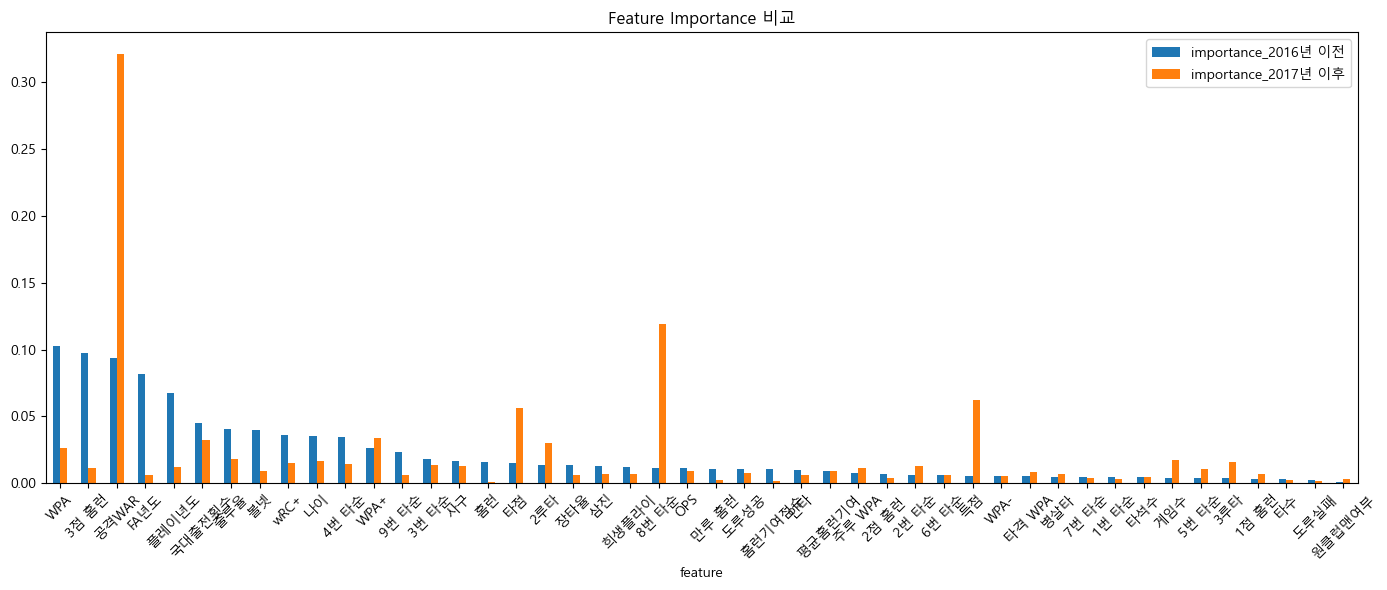

In [9]:
# 시각화
plot_importance_comparison(importance_pre, importance_post,
                           title1='2016년 이전', title2='2017년 이후')

In [11]:
# 중요도 비교 테이블 생성
comparison_df = pd.merge(
    importance_pre,
    importance_post,
    on='feature',
    suffixes=('_2016이전', '_2017이후')
)

# 변화량 계산 (2017 이후 - 2016 이전)
comparison_df['변화량'] = comparison_df['importance_2017이후'] - comparison_df['importance_2016이전']

# 변화량 높은 순 정렬
comparison_df = comparison_df.sort_values(by='변화량', ascending=False).reset_index(drop=True)

# 결과 출력
print(comparison_df)

   feature  importance_2016이전  importance_2017이후       변화량
0    공격WAR           0.093622           0.321362  0.227740
1    8번 타순           0.011177           0.118972  0.107795
2       득점           0.005680           0.062559  0.056879
3       타점           0.015411           0.056516  0.041105
4      2루타           0.013981           0.030138  0.016158
5      게임수           0.004245           0.017604  0.013359
6      3루타           0.003602           0.015733  0.012131
7     WPA+           0.026582           0.033795  0.007212
8    2번 타순           0.006156           0.013208  0.007051
9    5번 타순           0.004028           0.010294  0.006266
10   1점 홈런           0.003159           0.007094  0.003935
11  주루 WPA           0.007720           0.011181  0.003461
12  타격 WPA           0.005174           0.008165  0.002991
13     병살타           0.004944           0.007103  0.002159
14  원클럽맨여부           0.000755           0.002780  0.002025
15   6번 타순           0.006104           0.006502  0.0003

df.to_csv("data/야수_ 전처리_ver07_메인타순추가.csv", index=False)